In [1]:
__author__ = "Zewei 'Jason' Wu <wuz25@uchicago.edu>"
__version__ = '20230518'  # yyyymmdd; version datestamp of this notebook
__datasets__ = ['The Baryon Oscillation Spectroscopic Survey (BOSS)', 'SDSS DR12']  # datasets used in this notebook
__keywords__ = ['sdss', 'SDSS', 'galaxies', 'quasars']  # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/keywords.txt

# Characterizing the Baryonic Acoustic Oscillation from BOSS

*Jason Wu, Department of Astronomy and Astrophysics, The University of Chicago*

### Table of contents
* [Goals & notebook summary](#goals)
* [Background](#background)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [1. Loading galaxy data](#galaxy_data)
* [3. Visualizing the dataset](#visualization)
* [4. Loading random data](#randoms)
* [5. Two-Point correlation function](#correlation)
* [6. Co-Moving distances](#distance)
* [Additional work](#extensions)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals

* Load and characterize BOSS data
* Compute co-moving spatial distance
* Perform two-point correlation
* Replicate figure from [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512)

# Summary

In this notebook, we demonstrate a detection of the baryonic acoustic oscillation (BAO) peak by constructing a simple 3d co-moving spatial correlation function using data from the [The Baryon Oscillation Spectroscopic Survey (BOSS)](http://www.sdss3.org/surveys/boss.php) released a part of the [SDSS DR12](https://www.sdss4.org/dr12/). In particular, we use the BOSS catalogs and randoms collected by Florian Beutler [here](https://fbeutler.github.io/hub/boss_papers.html).
We generally follow the procedure described in [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512), which was the first study to measure the BAO peak in data from SDSS. We are able to discern a BAO imprint at the typical distance scale of $100\ h^{-1} {\rm Mpc}$.

This notebook was originally generated as part of the final project for ASTR285 "Science with Large Astronomical Surveys" at the University of Chicago.

<a class="anchor" id="background"></a>
# Background

**Baryonic Acoustic Oscillations (BAO)** are fluctuations in the density of baryonic matter formed by acoustic density waves in the primordial plasma of the early universe. They are frozen into the matter distribution at recombination and stretched out by the expansion of the universe. They are imprinted into the cosmic web and can be measured in the distribution of galaxies. In terms of cosmology, they are important because they provide an independent "standard ruler" to measure the expansion rate of the universe and how that rate has changed throughout cosmic history.

## Early Universe

The early universe is so hot and dense that matter existed in the form of plasma, made of electrons and baryons (which include protons and neutrons). In this environment, photons bounced from one baryon to another via Thompson scattering, creating pressure within the plasma.

Now imagine an overdense region of the primordial plasma. While this region of overdensity gravitationally attracts matter towards it, the heat of photon-matter interactions creates a large amount of outward pressure. These counteracting forces of gravity and pressure are what created density "oscillations," analogous to sound waves created in air via pressure differences.

## Recombination

As the universe expanded, the plasma cooled to below 3000 K — a low enough energy such that the electrons and protons in the plasma could combine to form neutral hydrogen atoms. This neutral matter is transparent to photons, allowing them to escape. The pressure that once dominated the universe is overwhelmed by gravity, and the rippling sound waves eventually became the **matter density imprints** that would form galaxies. Therefore, one would expect to see a greater number of galaxy pairs separated by a characteristic **sound horizon distance scale** than by other length scales. We can observe this exact remnant of BAO today by looking at distributions of galaxies and galaxy clusters spread across the universe.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

* SDSS and BOSS: https://www.sdss4.org/collaboration/citing-sdss/

<a class="anchor" id="import"></a>
# Imports and setup

The following two cells setup the imports as well as the graphing parameters. We assume that the user is running in the `ASTR285` kernel on datalab, which has the `treecorr` package pre-installed. Alternatively, the user can follow the instructions for installing `treecorr` [here](https://rmjarvis.github.io/TreeCorr/_build/html/overview.html#installation).

Note the second cell relies on `data/def.mplstyle` to run, so make sure to copy the full directory.

In [2]:
# Standard python imports
%matplotlib inline

# system imports
from os.path import join
import os
import glob
import inspect
from importlib import reload
import warnings

# standard scientific computing imports
import numpy as np
import pylab as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import pandas as pd

# astropy imports
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const
import astropy.units as u
from astropy.io import fits

# healpy is a visualization library for spherical coordinates
import healpy as hp
# treecorr is used to construct two-point correlation functions
import treecorr

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('data/def.mplstyle')

def plot_prettier(dpi=200, fontsize=10, usetex=True): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=usetex)
plot_prettier(dpi=400, usetex=False)

<a class="anchor" id="galaxy_data"></a>
# Loading Galaxy Data

Load the CMASS data sample from the Baryon Oscillation Spectroscopic Survey (BOSS).
Only the Southern half of the survey is used. The analysis could extend to the full dataset, but this is sufficient for the purposes of seeing the BAO.
The dataset is pre-selected for Luminous Red Galaxies (LRGs) using two different color selections for low-redshift ($z < 0.45$) and high-redshift ($z > 0.45$) galaxies. The specifics are noted in this [SDSS page](https://classic.sdss.org/dr7/products/general/edr_html/node53.html).

In [4]:
# relative path to the working directory
rel_path = '/'.join(os.getcwd().split('/')[5:])
print(rel_path)

JasonWooo-notebooks-latest/05_Contrib/ExtraGalactic/BaryonicAcousticOscillations


In [5]:
filename = 'data/galaxy_DR12v5_CMASSLOWZTOT_South.fits'

# download the file if it doesn't exist
if os.path.exists(filename):
    print(f'File found at {filename}')
else:
    !wget --no-check-certificate -P {rel_path}/data/ https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz
    !gzip -d {rel_path}/data/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz

File found at data/galaxy_DR12v5_CMASSLOWZTOT_South.fits


Load the data and print the fields and number of objects in the dataset.

In [6]:
data = fits.open(filename)[1].data
print(data.dtype)
print(f'{len(data)} objects in data set')

(numpy.record, [('RA', '>f8'), ('DEC', '>f8'), ('RUN', '>i4'), ('RERUN', 'S12'), ('CAMCOL', '>i4'), ('FIELD', '>i4'), ('ID', '>i4'), ('ICHUNK', '>i4'), ('IPOLY', '>i4'), ('ISECT', '>i4'), ('FRACPSF', '>f4', (5,)), ('EXPFLUX', '>f4', (5,)), ('DEVFLUX', '>f4', (5,)), ('PSFFLUX', '>f4', (5,)), ('MODELFLUX', '>f4', (5,)), ('FIBER2FLUX', '>f4', (5,)), ('R_DEV', '>f4', (5,)), ('EXTINCTION', '>f4', (5,)), ('PSF_FWHM', '>f4', (5,)), ('AIRMASS', '>f4'), ('SKYFLUX', '>f4', (5,)), ('EB_MINUS_V', '>f4'), ('IMAGE_DEPTH', '>f4', (5,)), ('IMATCH', '>i4'), ('Z', '>f4'), ('WEIGHT_FKP', '>f4'), ('WEIGHT_CP', '>f4'), ('WEIGHT_NOZ', '>f4'), ('WEIGHT_STAR', '>f4'), ('WEIGHT_SEEING', '>f4'), ('WEIGHT_SYSTOT', '>f4'), ('NZ', '>f4'), ('COMP', '>f4'), ('PLATE', '>i4'), ('FIBERID', '>i4'), ('MJD', '>i4'), ('FINALN', '>i4'), ('TILE', '>i2', (3,)), ('SPECTILE', '>i4'), ('ICOLLIDED', '>i4'), ('INGROUP', '>i4'), ('MULTGROUP', '>i4')])
372601 objects in data set


## Magnitude Calibration

The magnitudes are given in five different versions of fluxes, using definitions provided in [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512). We believe that a set of similar cuts have already been applied to the CMASS sample, but the user could attempt to apply other magnitude cuts to obtain potentially more promising results.

The random dataset would, however, be hard to construct in this case, as the SDSS random does not come with magnitudes assigned. To see the BAO with 3d correlation, the two datasets need to share a similar distribution in the redshift-space. Therefore, we simply copy our initial data set into a new variable (`gal_df_cut`), which the user could replace with their own modified subselection if desired.

In [7]:
gal_df_cut = data.copy()

<a class="anchor" id="visualization"></a>
# Visualization of the Dataset

We make a few plots of the spatial distribution of our data. As a reminder, we are only looking at the southern portion of BOSS.

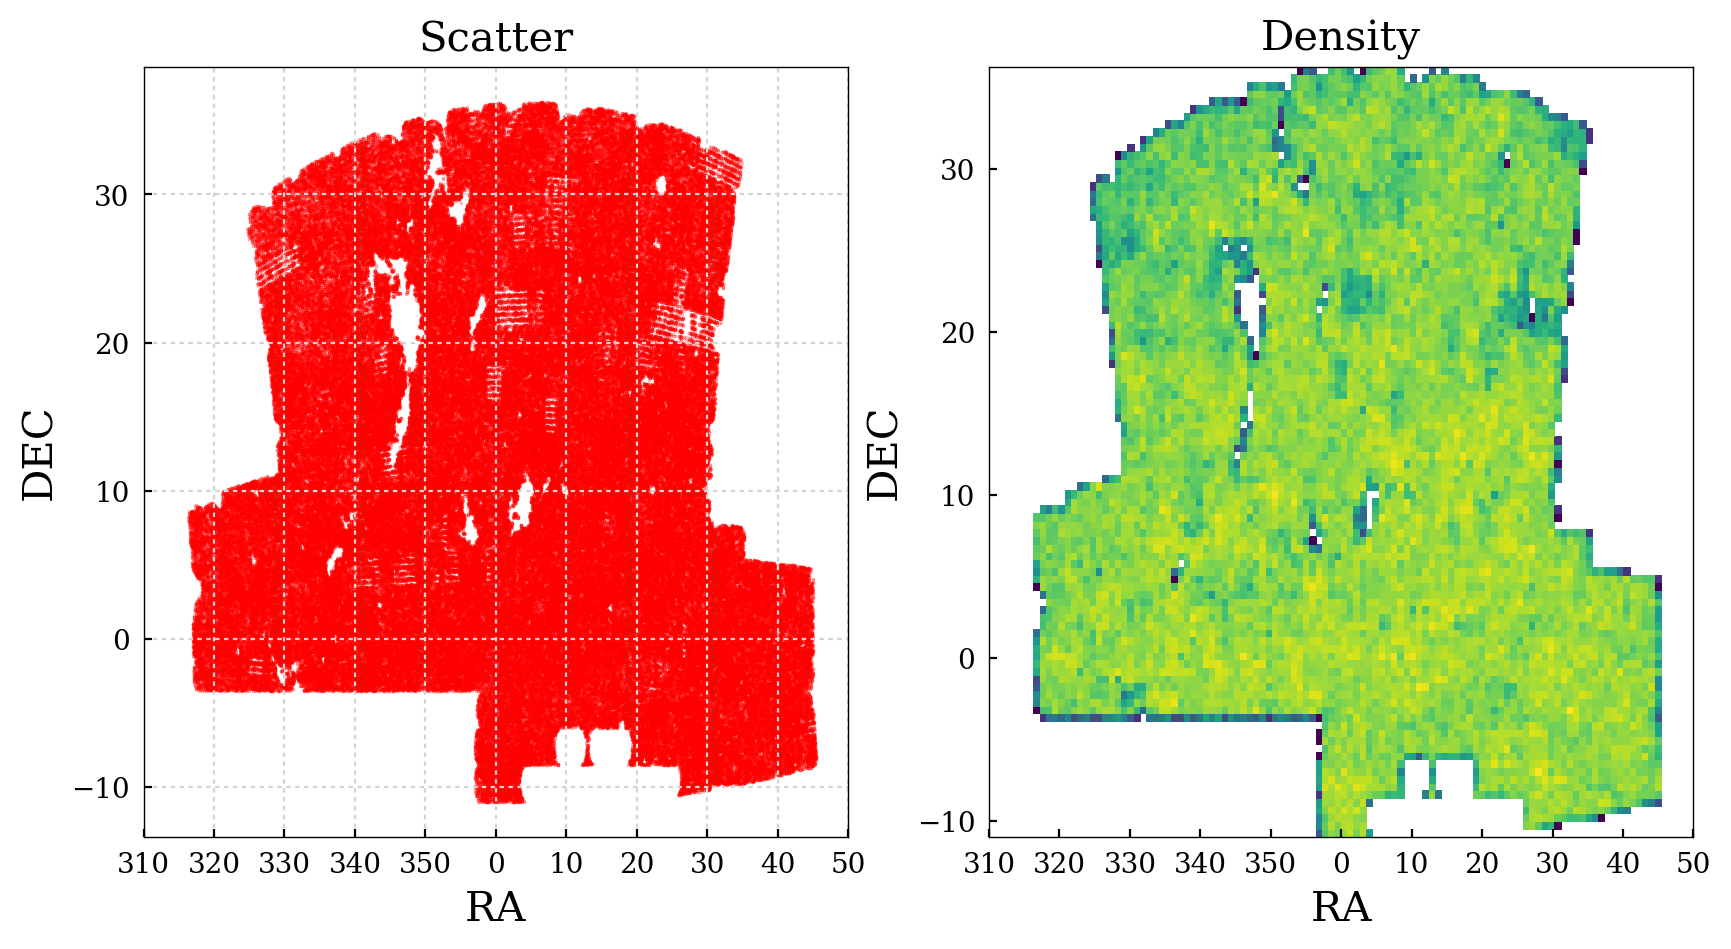

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# scatter plot on left
ax1.set_title('Scatter')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
wrapped_ind = gal_df_cut['RA'] < 100
wrapped_ra = gal_df_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax1.scatter(wrapped_ra, gal_df_cut['DEC'], marker='.', s=0.2, alpha=0.5, c='red')
xticks = np.arange(310, 420, 10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks%360)

# density plot on right
ax2.set_title('Density')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
wrapped_ind = gal_df_cut['RA'] < 100
wrapped_ra = gal_df_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax2.hist2d(wrapped_ra, gal_df_cut['DEC'], bins=100, norm=LogNorm())
xticks = np.arange(310, 420, 10)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks%360)

plt.show()

Show a mollwide visualization with the `healpy` module

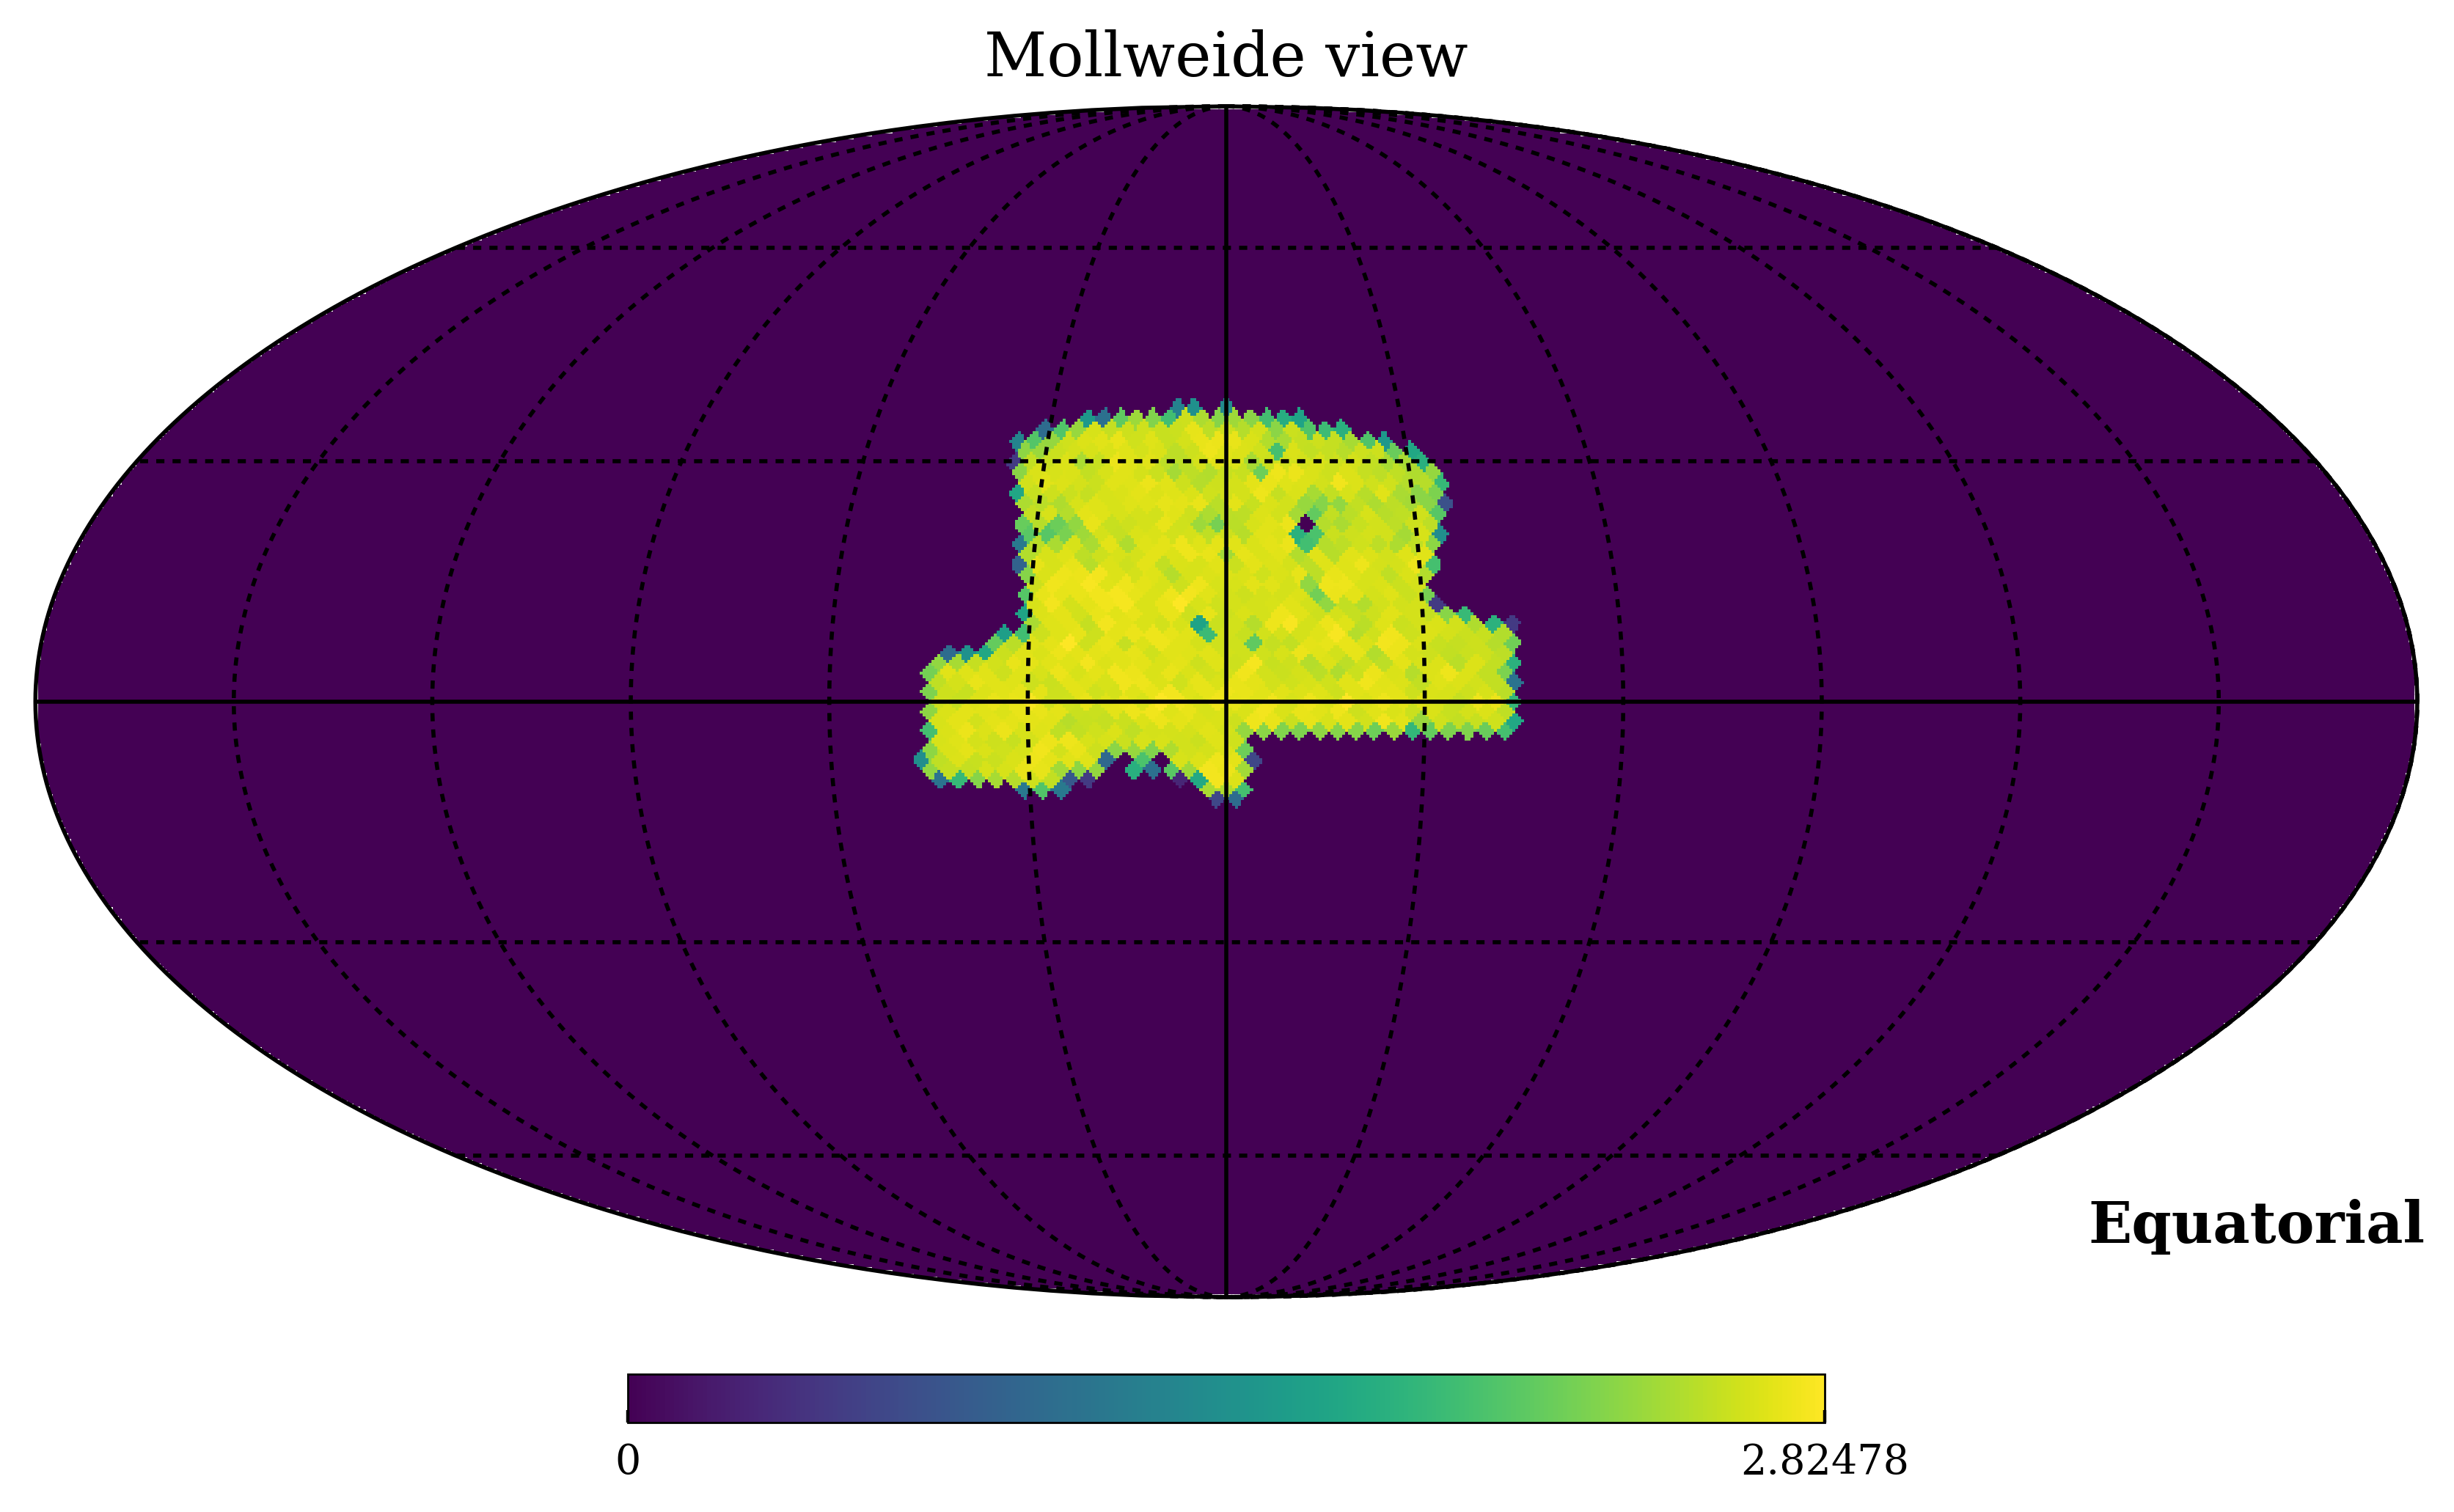

In [9]:
# healpy visualization
NSIDE = 32
# coords in the catalog
COORDS = SkyCoord(gal_df_cut['RA'], gal_df_cut['DEC'], unit=['deg','deg'])

# convert catalog coords to index of pixels
pix_ind = hp.ang2pix(NSIDE, COORDS.ra.value, COORDS.dec.value, lonlat=True)

unique_ind, density = np.unique(pix_ind, return_counts=True)
full_density = np.ones(hp.nside2npix(NSIDE))  # to remove gaps for the undersampled regions
full_density[unique_ind] = density

hp.mollview(np.log10(full_density), coord='C')  # C = celestial equatorial
hp.graticule()
plt.show()

<a class="anchor" id="randoms"></a>
# Loading Radom Data

Random data is also provided by SDSS/BOSS, and takes into account the instrumental bias, as well as selection bias of the survey. This is so that we wouldn't have to propagate the selection function.

In [10]:
filename = 'data/random0_DR12v5_CMASSLOWZTOT_South.fits'

# download the file if it doesn't exist
if os.path.exists(filename):
    print(f'File found at {filename}')
else:
    !wget --no-check-certificate -P {rel_path}/data/ https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz
    !gzip -d {rel_path}/data/random0_DR12v5_CMASSLOWZTOT_South.fits.gz

File found at data/random0_DR12v5_CMASSLOWZTOT_South.fits


Load the randoms and print the fields and number of objects.

In [11]:
rand = fits.open(filename)[1].data
print(rand.dtype)
print(f'{len(rand)} points in total in random')

(numpy.record, [('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('NZ', '>f8'), ('IPOLY', '>i2'), ('ISECT', '>i2'), ('ZINDX', '>i4'), ('SKYFLUX', '>f4', (5,)), ('IMAGE_DEPTH', '>f4', (5,)), ('AIRMASS', '>f4'), ('EB_MINUS_V', '>f4'), ('PSF_FWHM', '>f4', (5,))])
18544998 points in total in random


To speed up subsequent calculations, we select a random set of the randoms matched in size to our data sample. Using the full random set will take more time, but should reduce the uncertainty in the measurement.

In [12]:
# subselect the same number of samples (only necessary if cutting the data set)
rand_cut = np.random.choice(rand, size=len(gal_df_cut), replace=False)
#rand_cut = rand

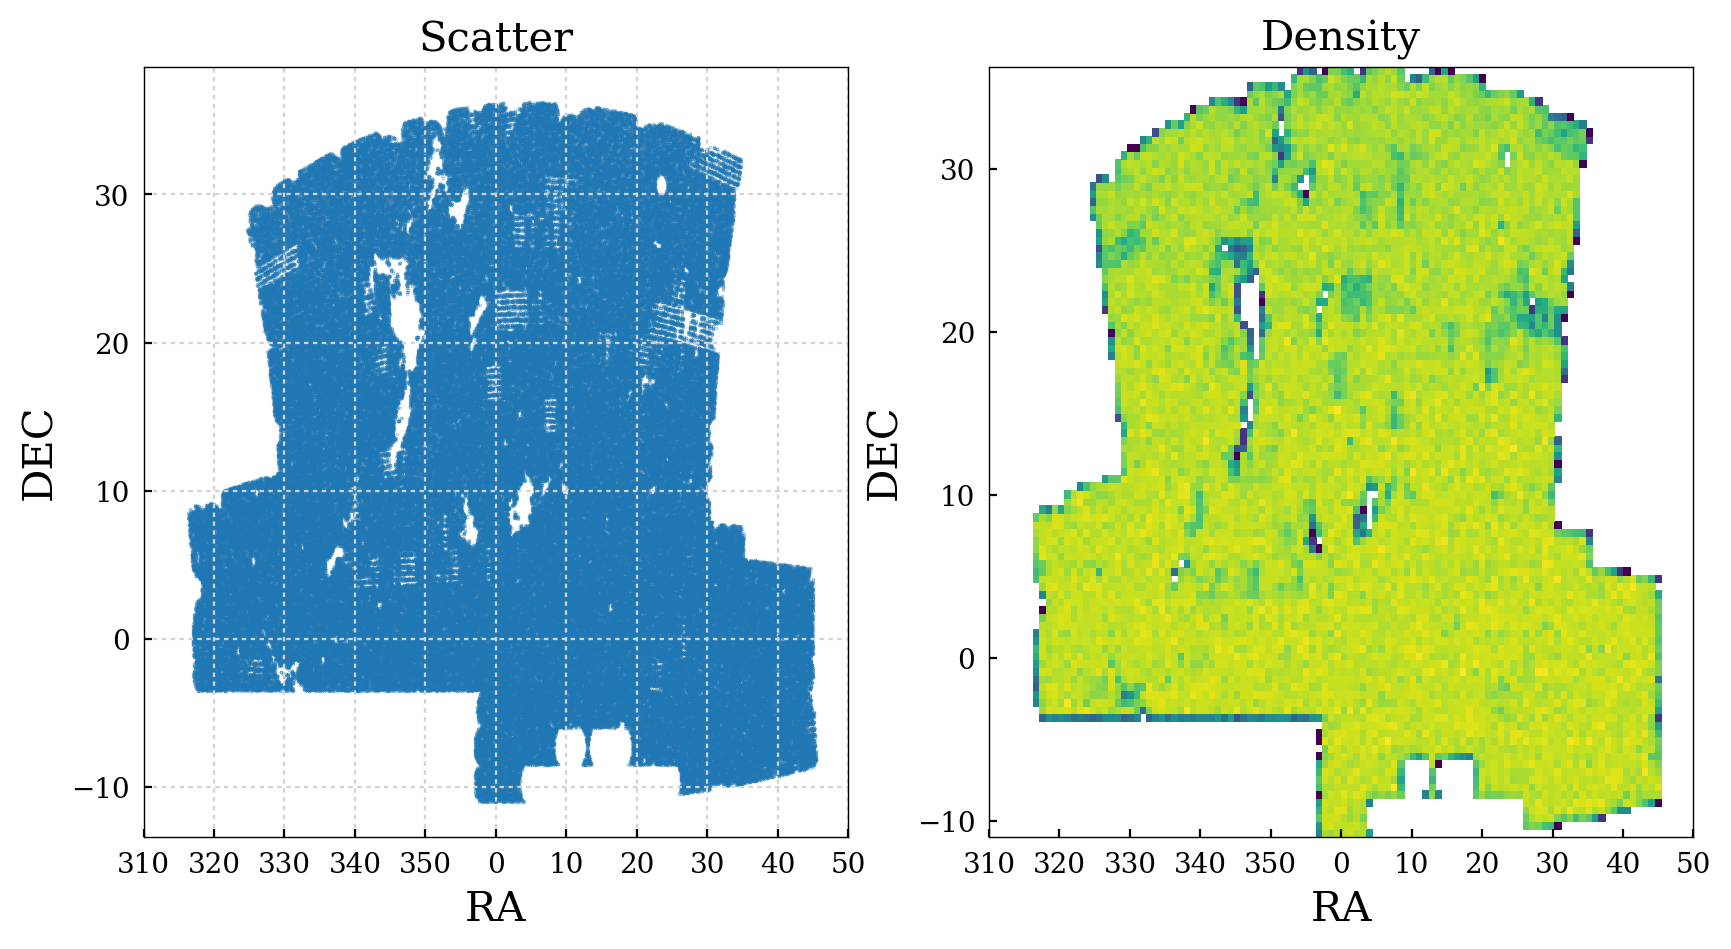

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# scatter plot on left
ax1.set_title('Scatter')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
wrapped_ind = rand_cut['RA'] < 180
wrapped_ra = rand_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax1.scatter(wrapped_ra, rand_cut['DEC'], marker='.', s=0.2, alpha=0.5, c='C0')
xticks = np.arange(310, 420, 10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks%360)

# density plot on right
ax2.set_title('Density')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
wrapped_ind = rand_cut['RA'] < 100
wrapped_ra = rand_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax2.hist2d(wrapped_ra, rand_cut['DEC'], bins=100, norm=LogNorm())
xticks = np.arange(310, 420, 10)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks%360)

plt.show()

Print the number of data points in the galaxy and random set

In [14]:
len(gal_df_cut), len(rand_cut)

(372601, 372601)

## Distribution in redshift-space

As mentioned in the previous section, the galaxy and random datasets need to share a similar distribution in the redshift-space, in order to see the BAO with this type of 3d correlation.

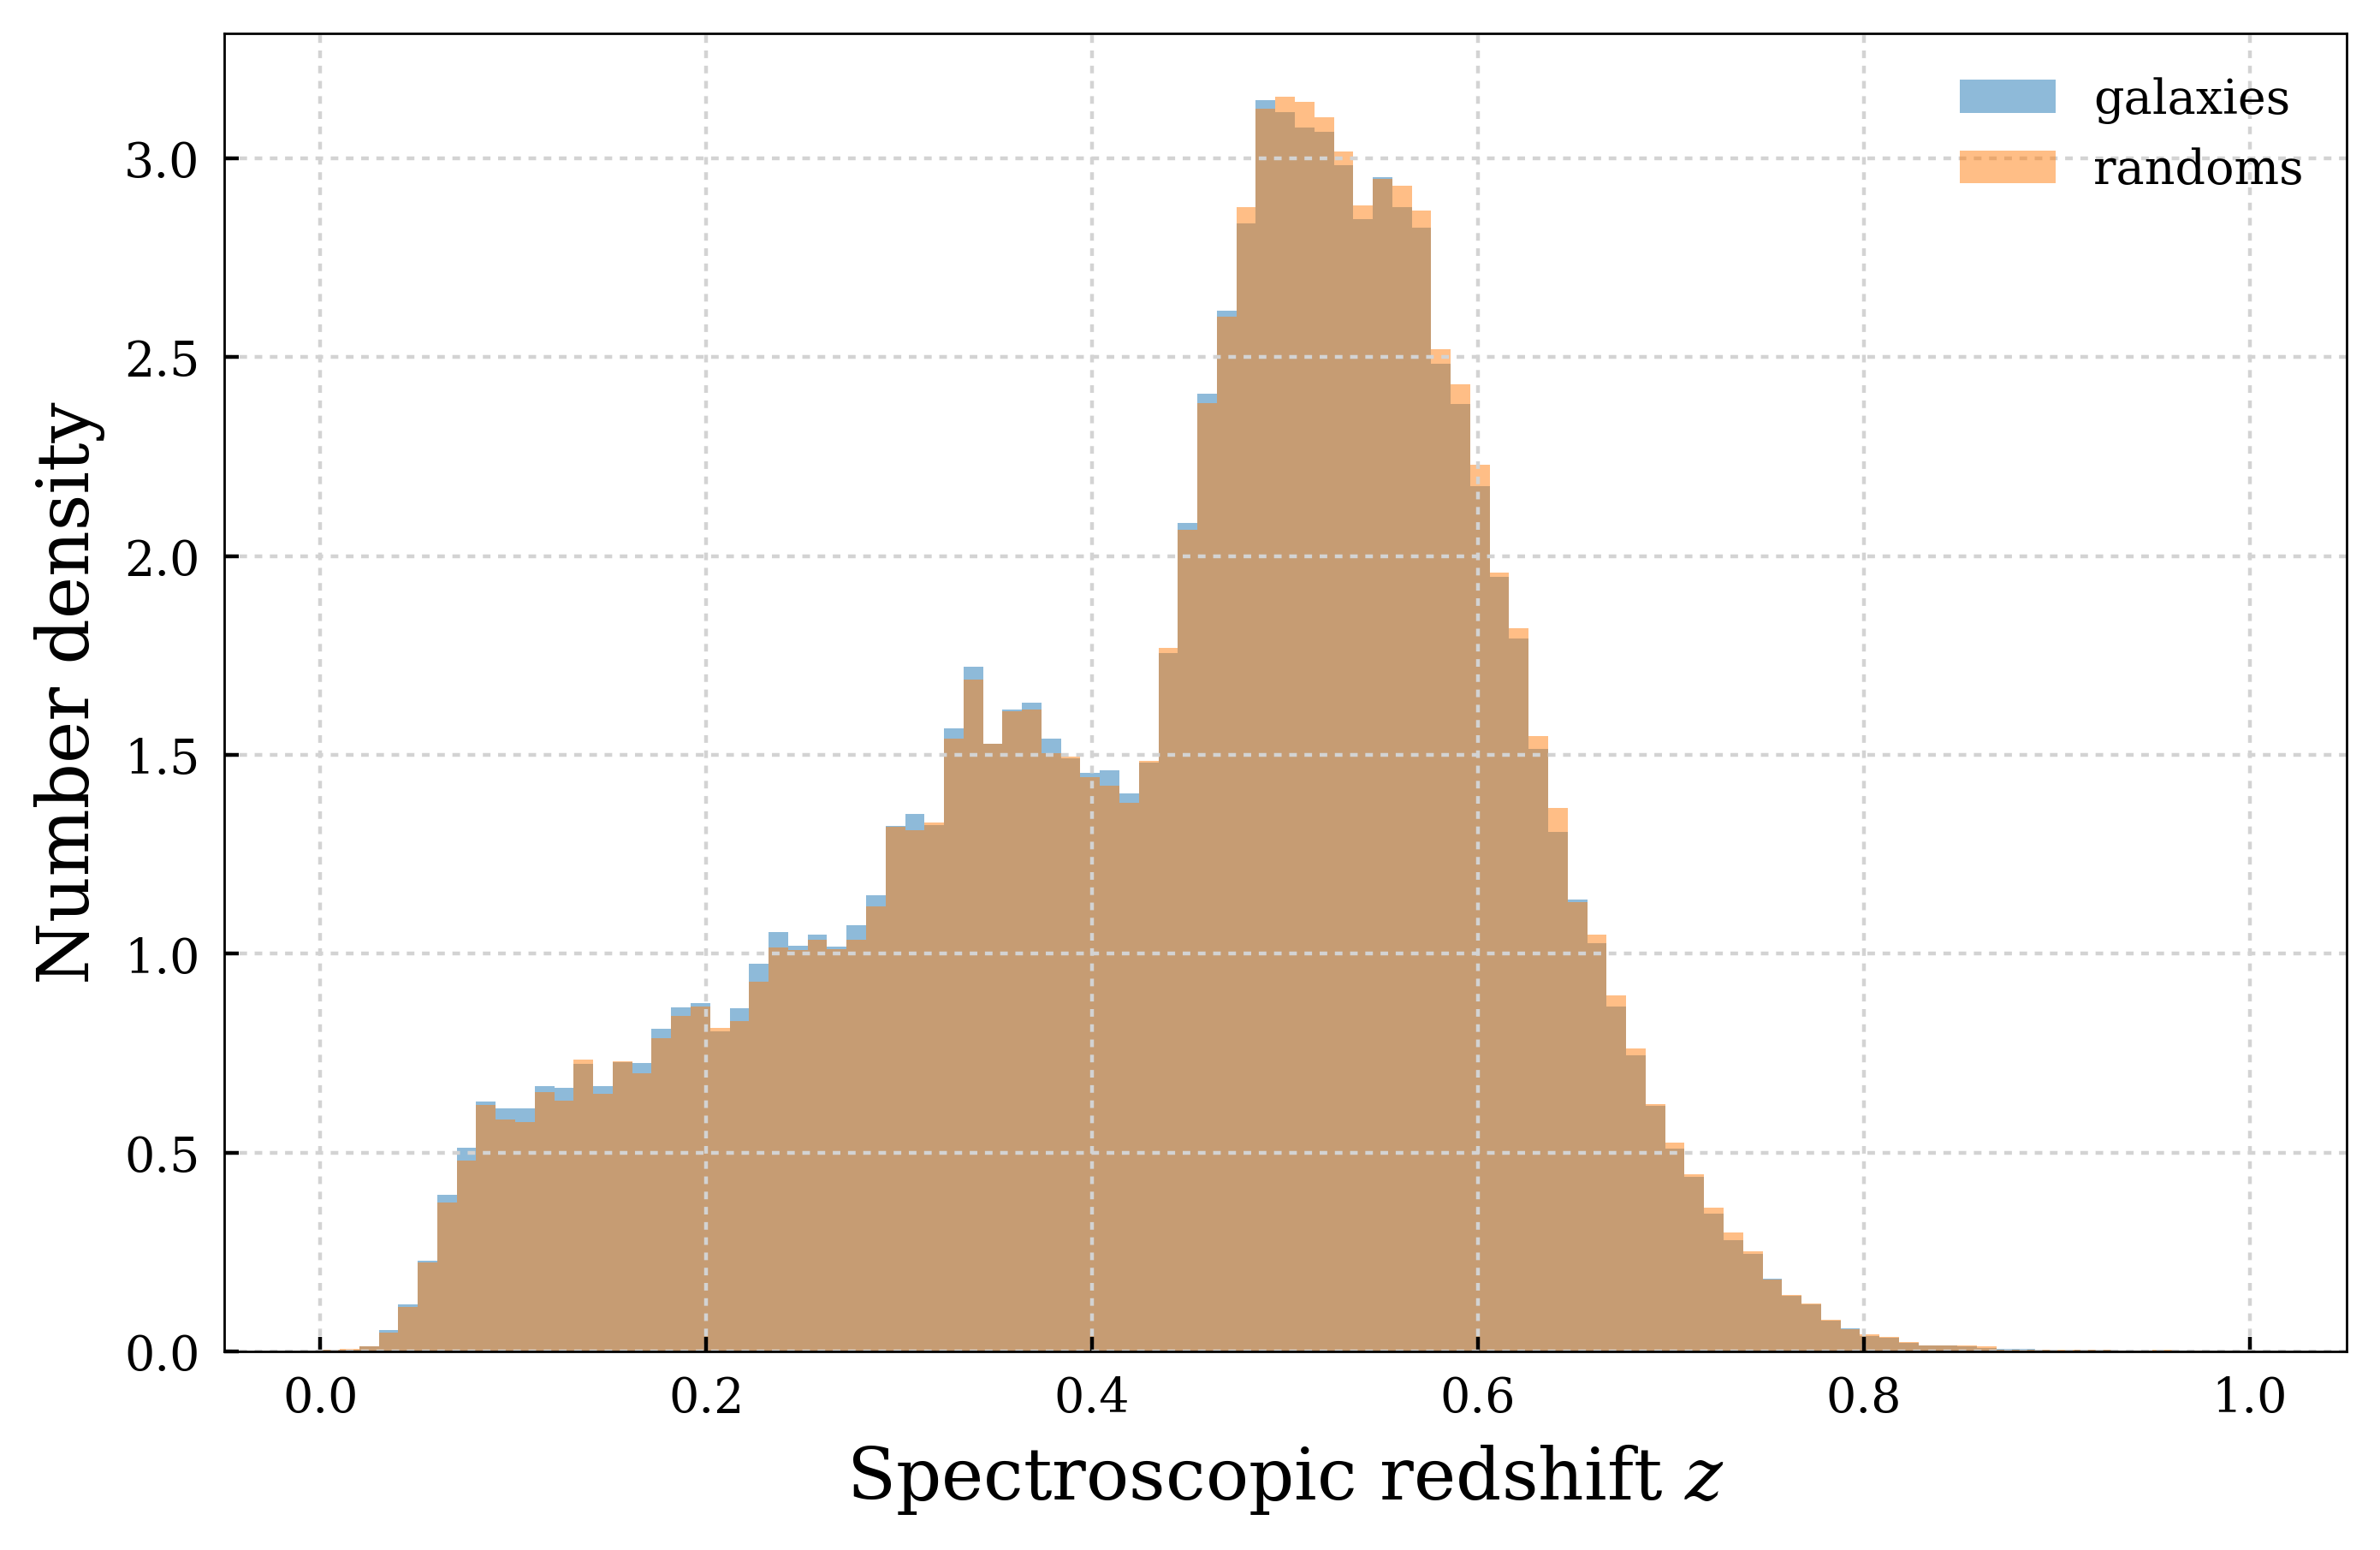

In [15]:
plt.figure(figsize=(8,5))
plt.hist(gal_df_cut['Z'], alpha=0.5, label='galaxies', bins=np.linspace(0, 1, 100), density=1)
plt.hist(rand_cut['Z'], alpha=0.5, label='randoms', bins=np.linspace(0, 1, 100), density=1)
plt.legend()
plt.xlabel('Spectroscopic redshift $z$')
plt.ylabel('Number density')
plt.show()

<a class="anchor" id="correlation"></a>
# Two-Point correlation function

To construct the correlation function, the data points have to be mapped onto three-dimensional space. This is done by calculating the co-moving distances inferred from spectroscopic redshifts of the objects.
For the purposes of our analysis, we use flat ΛCDM paradigm as the cosmology of our universe.

In [16]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [17]:
# value of h-unit
h = cosmo.H(0).value / 100.
print("little h:", h)

little h: 0.7


## Calculate two-point correlation function estimator

We use the [Landy-Szalay et al 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...412...64L/abstract) estimator to calculate the correlation function. This estimator is described by the formula:

$$\frac{dd-2dr+rr}{rr},$$

which is known to accurately reproduce small-scale structures like galaxy clusters, as well as large-scale cosmologies like the BAO peak. It also has an error estimation which could be easily calculated.

In [18]:
def tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
            min_sep=10, max_sep=200, bin_size=5):  # binning analysis
    """ Calculate the two-point correlation function using co-moving distances. """
    # cosmology
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    h = cosmo.H(0).value / 100
    
    # Cartesian coordinates in co-moving frame
    # for member galaxies in catalog
    dec_gal_rad = dec_gal.to(u.rad)  # convert to radians
    ra_gal_rad = ra_gal.to(u.rad)
    xgal = D_gal * np.cos(dec_gal_rad) * np.cos(ra_gal_rad)
    ygal = D_gal * np.cos(dec_gal_rad) * np.sin(ra_gal_rad)
    zgal = D_gal * np.sin(dec_gal_rad)
    # for member galaxies in random
    dec_rand_rad = dec_rand.to(u.rad)  # convert to radians
    ra_rand_rad = ra_rand.to(u.rad)
    xrand = D_rand * np.cos(dec_rand_rad) * np.cos(ra_rand_rad)
    yrand = D_rand * np.cos(dec_rand_rad) * np.sin(ra_rand_rad)
    zrand = D_rand * np.sin(dec_rand_rad)
    
    # filter any NANs
    mask = ~np.isnan(xgal)
    g_cat = treecorr.Catalog(x=xgal[mask],
                             y=ygal[mask],
                             z=zgal[mask])
    mask = ~np.isnan(xrand)
    r_cat = treecorr.Catalog(x=xrand[mask],
                             y=yrand[mask],
                             z=zrand[mask])

    # Run the correlation function
    # define dd
    dd = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, bin_type='Linear')
    dd.process(g_cat)

    # define rr
    rr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, bin_type='Linear')
    rr.process(r_cat)

    # define dr
    dr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, bin_type='Linear')
    dr.process(g_cat, r_cat)

    # error calculations
    xi, varxi = dd.calculateXi(rr=rr, dr=dr)  # value and error
    r = np.exp(dd.meanlogr)  # bins
    rh = r  # in Mpc/h
    r = r/h  # in Mpc
    sig = np.sqrt(varxi)
    
    return r, rh, xi, sig

In [19]:
def tpcf_plot(r, rh, xi, sig,
              xlog=False, ylog=False,                            # log the axis
              xmin=10, xmax=150, xlabels=np.arange(0, 160, 20),  # x-axis
              ymin=-30, ymax=20,                                 # y-axis
              fig_path='graphs/ls_spatial_correlation'):
    """ Plot the r^2 xi correlation function. """
    fig, ax = plt.subplots(figsize=(8,5), dpi=300)
    # plot value and error
    ax.errorbar(rh, (r**2) * xi, yerr=(r**2) * sig, color='blue',
                marker='o', markersize=5, lw=2, ls='',
                elinewidth=1, capsize=0, alpha=1)

    # axis parameters
    if xlog:
        ax.set_xscale('log', nonpositive='clip')
    ax.set_title('L-S Spatial Correlation')
    # x-axis
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'${\rm Comoving\ Separation\ } r\ (h^{-1} {\rm Mpc})$')
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels)
    ax.tick_params(top=True, right=True)
    # y-axis
    if ylog:
        ax.set_yscale('log', nonpositive='clip')
    ax.set_ylabel(r'$r^2 \xi(r)$')
    ax.set_ylim(ymin, ymax)
    plt.show()
    fig.savefig(fig_path)

### RA and DEC of the galaxies

In [20]:
# fetch for both catalog and randoms
ra_gal = (gal_df_cut['RA'] * u.deg)
dec_gal = (gal_df_cut['DEC'] * u.deg)
ra_rand = (rand_cut['RA'] * u.deg)
dec_rand = (rand_cut['DEC'] * u.deg)

<a class="anchor" id="distance"></a>
# Co-Moving Distances

We seek to replicate Figure 3 of [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512) by calculating the two-point correclation function using traditional definition of the co-moving distance.

Without using any arbitrary criteria, the traditional definition for comoving distance is as follows:

$$d_C(z) = d_H \int_0^z \frac{dz'}{E(z')}$$

We use the `cosmo.comoving_distance(z)` function in the `astropy` module to simplify our calculations.

Note that this calculation can take a while 

In [21]:
%%time
# comoving distance for galaxies
D_gal = cosmo.comoving_distance(gal_df_cut['Z']) * h  # h^-1 * Mpc
# comoving distance for randoms
D_rand = cosmo.comoving_distance(rand_cut['Z']) * h  # h^-1 * Mpc

CPU times: user 6.16 s, sys: 26.6 ms, total: 6.18 s
Wall time: 6.18 s


Calculate the correlation function estimator.

In [22]:
%%time
r, rh, xi, sig = tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
                         min_sep=10, max_sep=200, bin_size=5)

CPU times: user 12min 27s, sys: 3.23 s, total: 12min 30s
Wall time: 19.2 s


Following Eisenstein et al. 2004, the correlation function $\xi(r)$ obtained from `treecorr` is multiplied with $r^2$ to better demonstrate the peak.

Note that the error estimate used here is without any bootstrap methods with regards to different patches.

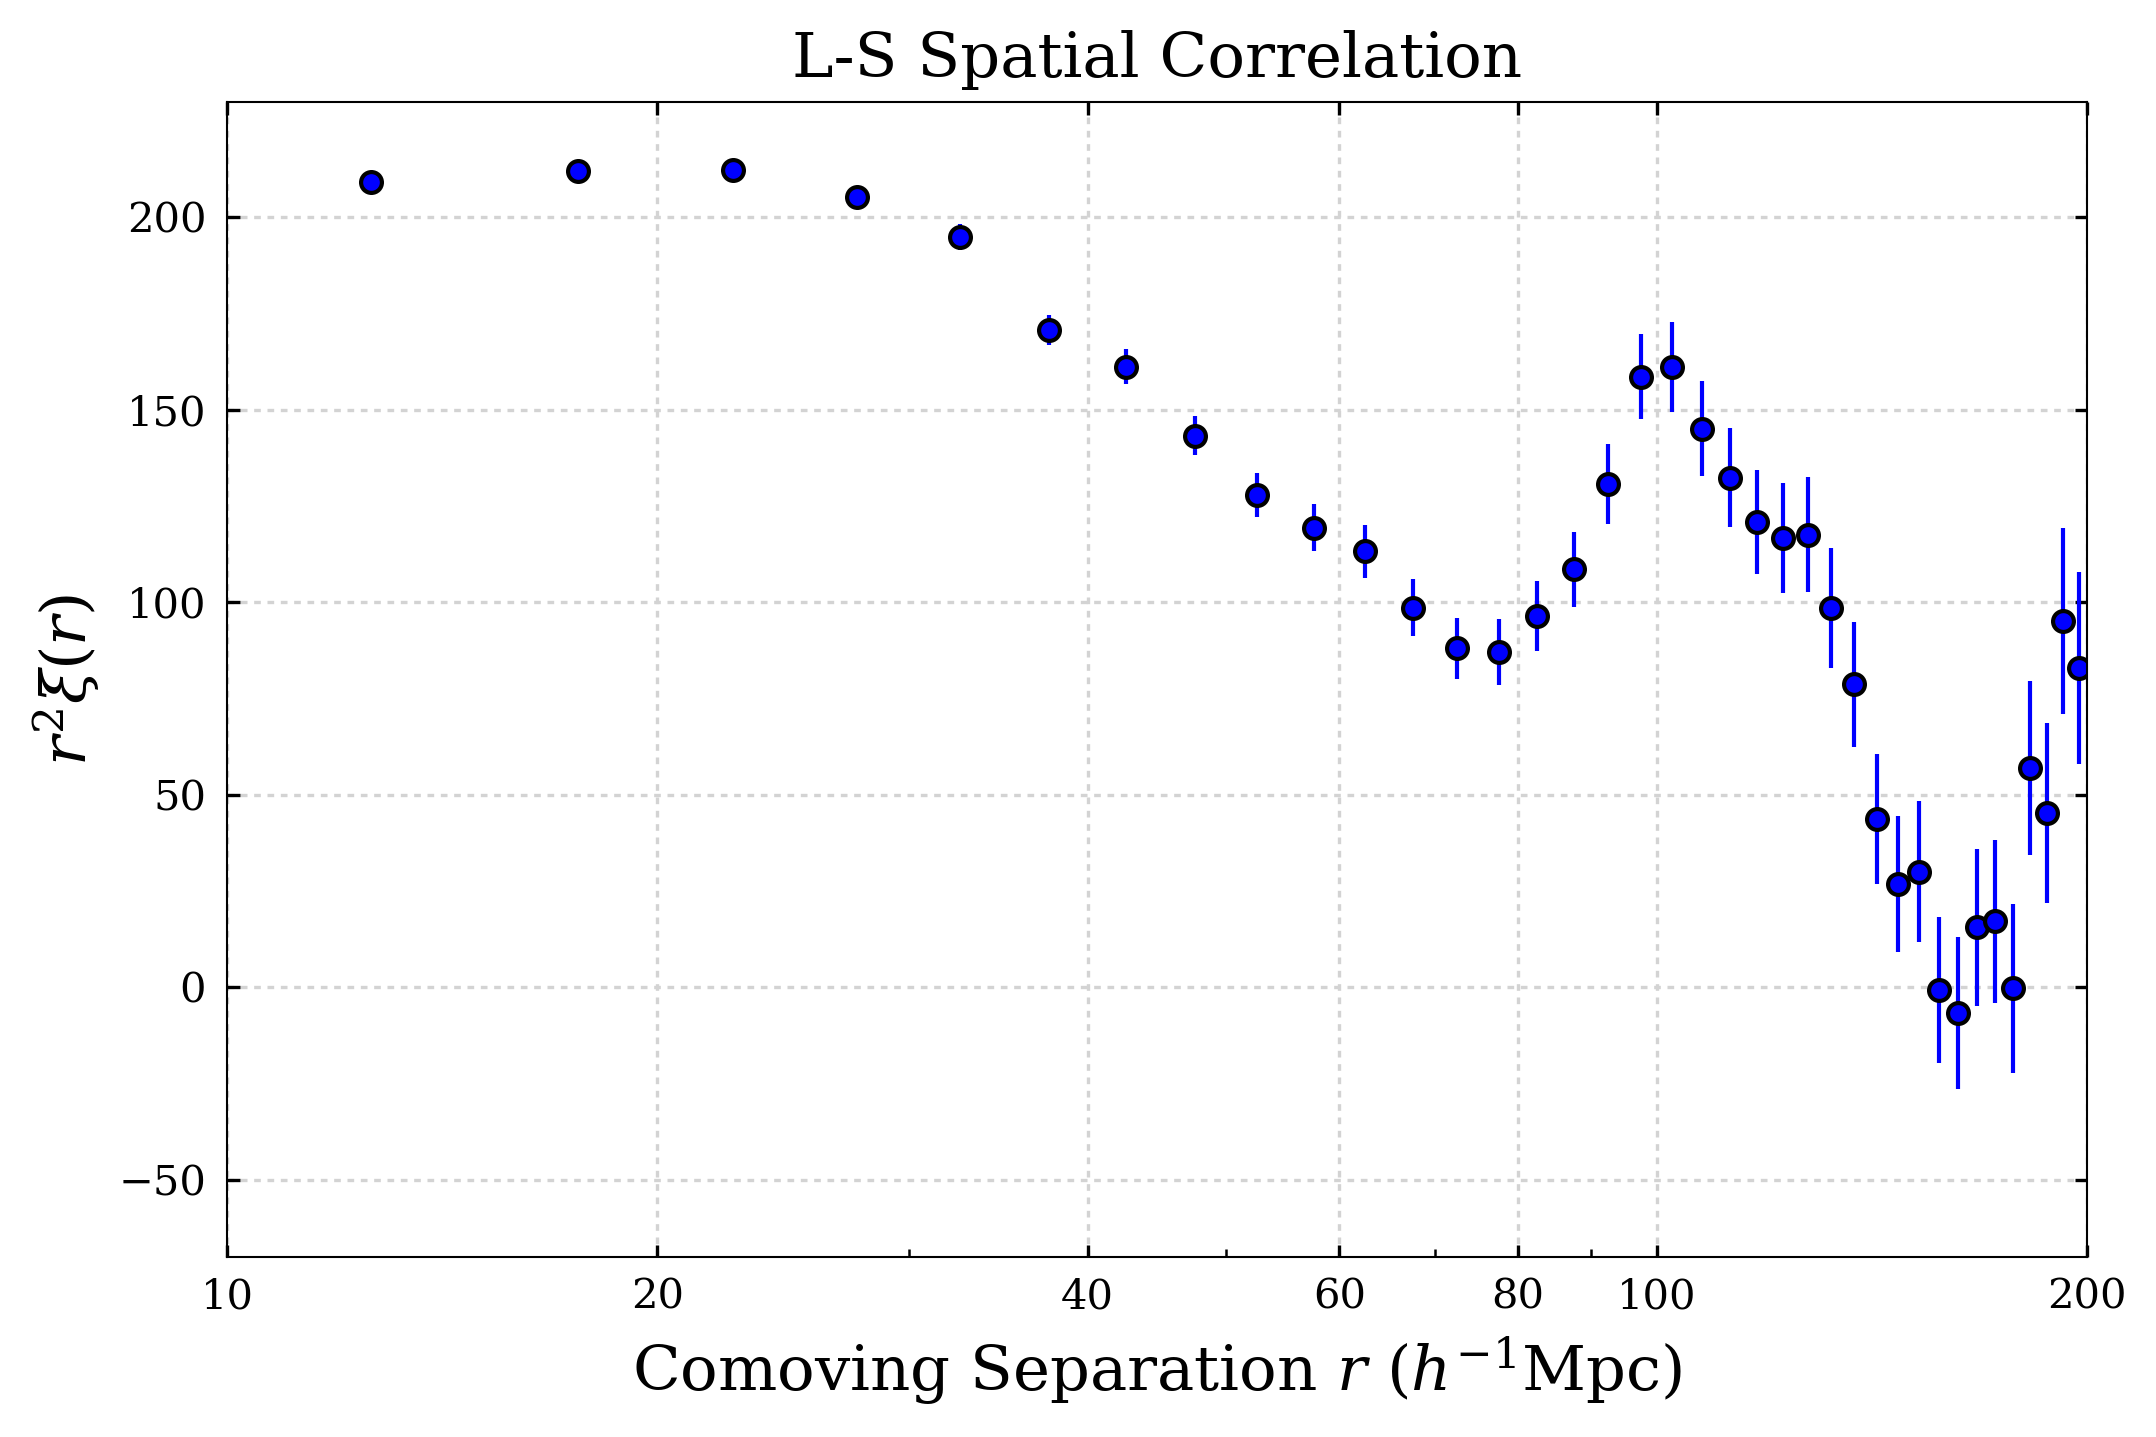

In [23]:
xmin, xmax = 10, 200
ymin, ymax = -70, 230
xlabels = [10, 20, 40, 60, 80, 100, 200]

tpcf_plot(r, rh, xi, sig,
          xlog=True, ylog=False,                             # log the axis
          xmin=xmin, xmax=xmax, xlabels=xlabels,             # x-axis
          ymin=ymin, ymax=ymax,                              # y-axis
          fig_path='graphs/spatial_eisenstein')

<a class="anchor" id="extentions"></a>

# Additional Work

The reader is encouraged to explore possibilities of future work on their own. Below are a few suggestions of additional analysis:

### Full Catalog

This notebook only used data from southern portions of [BOSS](https://fbeutler.github.io/hub/boss_papers.html), which consists of less than half of the survey. The northern dataset could be retrieved similarly, and comes with its own random dataset. The reader is thus encouraged to extend their analysis onto the full DR12 points for better results.

### Statistical Methods

The error bars on the plots are natively produced by the `treecorr` package. Other statistical methods of bootstrapping could be used to generate more convicing error bars. The Jackknife method is widely used by astronomers, and involves taking different patches of the sky and estimating variation within the model estimate. `treecorr` even has [documentation](https://rmjarvis.github.io/TreeCorr/_build/html/cov.html) on calculating covariance with jackknife.

### Fitting the Accoustic Feature

[Anderson et al 2012](https://arxiv.org/abs/1203.6594) fit for the position of the BAO feature to measure the distance to the mean redshift of the BOSS sample relative to the sound horizon. They define the distance combination:

$$D_V \equiv {[cz(1+z)^2D_A^2H^{-1}]}^{1/3},$$

where the fiducial value for their chosen cosmology is $(D_V/r_s)_{\rm fid} = 13.23$ when the sounds horizon $r_s$ is defined as in [Eisenstein & Hu 1998](https://arxiv.org/abs/astro-ph/9709112). 
Any deviation of the true distance-redshift relation from the fiducial choice can be related to the distance to the weighted-mean redshift of the sample by the parameter $\alpha$, such that

$$D_V / r_s = \alpha (D_V /r_s)_{\rm fid}.$$

The following example function calculates $D_V$ as a function of redshift in the standard LCDM model. It could be used along with a measurement of the sound horizon scale, $r_s [h^{-1} {\rm Mpc}]$, at a given redshift, $z$, to estimate distance-redshift relation.

In [24]:
# distance parameter
def calc_Dv(z, alpha = 1):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    D_a = cosmo.angular_diameter_distance(z)  # the angular diameter distance
    # comoving distance
    H = cosmo.H(z)
    D_v = (const.c * z * (1+z)**2 * D_a**2 * H**(-1)) ** (1/3)
    return D_v.to(u.Mpc)

### Model fit

One of the main motivations to use the sound horizon definition for co-moving distance is to constrain the cosmological parameters. Later sections of [Anderson et al 2012](https://arxiv.org/abs/1203.6594) can serve as a guide. The reader can also use MCMC and power spectrum (with respect to length scale) to extract more cosmological data from the BAO curve.

<a class="anchor" id="resources"></a>
# Resources and references

**Attached are some resources and "further reading" links relevant to this notebook.**

"Cosmolgical Distance Measurements", Scholarly Community Encyclopedia. https://encyclopedia.pub/entry/30206

"BOSS: Dark Energy and the Geometry of Space", SDSS-III. https://www.sdss3.org/surveys/boss.php

"Luminous Red Galaxies", SDSS-III. https://classic.sdss.org/dr7/products/general/edr_html/node53.html

"SDSS Data Release 12", SDSS. https://classic.sdss.org/dr7/products/general/edr_html/node53.htmlhttps://www.sdss4.org/dr12/

BOSS Data Download. https://fbeutler.github.io/hub/boss_papers.html

"A Detailed Look at Estimators for the Two-Point Correlation Function, their Variance and a Verification of the TreeCorr-Algorithm with LoTSS Data", Marian Biermann, Universität Bielefeld. https://www2.physik.uni-bielefeld.de/fileadmin/user_upload/theory_e6/Master_Theses/MA_MarianBiermann.pdf

**Papers referenced in this paper:**

[SDSS & Connolly et al 2002](https://arxiv.org/abs/astro-ph/0107417)

[Landy-Szalay et al 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...412...64L/)

[Eisenstein & Hu 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...496..605E/)

[Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512)

[Anderson et al 2012](https://arxiv.org/abs/1203.6594)